# Documentation

This notebook contains a couple of examples of how to use the code in this git repo for computing the free additive or multiplicative distribution of (sufficiently nice) distributions.

### Defining the input measures

The input of our free convolution algorithms are two measures mu1 and mu2 that are elements of the class ''spectral_measure''. To define a measure, the user has two options: use one of the predefined measures, or set support and density manually.

In [1]:
import spectral_measure
mu = spectral_measure.spectral_measure()

For the pre-implemented measures, we can choose one of the following:

- Semicircle of parameter k -> semicircle distribution with support on the interval [-2k, 2k]

In [2]:
mu.set_semicircle(1)

- Marchenko-Pastur with parameter lambda in (0,1)

In [3]:
mu.set_marchenko_pastur(0.7)

- Uniform distribution on the interval [a, b]

In [4]:
mu.set_uniform(-2, 3)

- A discrete measure in the points ''atoms'' (an array) with weights ''weights'' (another array). Note that the sum of the weights must be 1

In [5]:
atoms = [-1, 0, 1]
weights = [0.2, 0.2, 0.6]
mu.set_discrete(atoms, weights)

- The ''weird'' measure from the paper. This has the bad property that its Cauchy transform is not invertible, but the nice property that our algorithm still works!

In [6]:
mu.set_weird()

- A shifted semicircle distribution with parameter k, that is, a semicircle distrbution on the interval [k, 5k]

In [7]:
mu.set_shifted_semicircle(2)

- A truncated version of the semicircle distrbution and shifted semicircle distribution (with parameter k), in which the left half of the weight is concentrated in the point 0 or 3k, respectively

In [8]:
mu.set_truncated_semicircle(1)
mu.set_truncated_semicircle_2(1)

Alternatively, one can define their own measure, by setting the support and then a density or some atoms and weights, or both. The density is a lambda function corresponding to $f(t) \mathrm{d}t = \mathrm{d} \mu(t)$. Here is an example. At least one between density and atoms are required.

In [9]:
del(mu)
mu = spectral_measure.spectral_measure()
mu.set_support(0, 1)
my_density = lambda t: 1.5 * t**2
mu.set_density(my_density)
mu.set_atoms([0, 1], [0.25, 0.25])

We use predefined measures in the rest of this tutorial. For example, we take $\mu_1$ to be a semicircle distribution with parameter $k=1$ and $\mu_2$ to be the uniform distrbution on the interval $[-1, 2]$.

In [10]:
mu1 = spectral_measure.spectral_measure()
mu1.set_semicircle(1)
mu2 = spectral_measure.spectral_measure()
mu2.set_uniform(-1, 2)

### Playing with the input measures

We can plot the density of the measures with the plot() function in the spectral_measure class. Two arguments are needed: the color and the label.

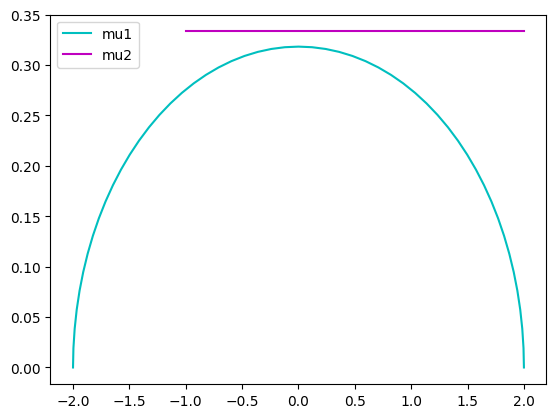

In [11]:
import matplotlib.pyplot as plt
mu1.plot('c', 'mu1')
mu2.plot('m', 'mu2')
plt.legend()

For the predefined measures, one can also sample a random matrix of size n x n whose eigenvalues converge, asymptotically when $n \to \infty$, to the chosen distribution. For example, in the case of the semicircle distribution the matrix is chosen as an $n \times n$ matrix $A = \frac{k}{\sqrt n}(B + B^T)$ where $B$ is an upper triangular matrix with iid $N(0,1)$ entries. The following example visualizes the empirical eigenvalue distribution of a matrix of size $1000 \times 1000$ corresponding to the semicircle distribution.

/home/alice/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/alice/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


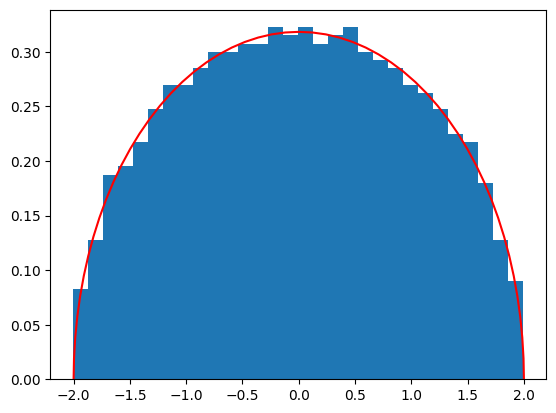

In [12]:
n = 1000
A1 = mu1.get_random_matrix(n)
import scipy
import numpy
E1 = scipy.linalg.eigvals(A1)
n_bins = 30
(counts, bins) = numpy.histogram(E1, bins=n_bins)
plt.hist(bins[:-1], bins, weights=n_bins / (n * (mu1.b - mu1.a)) * counts)
mu1.plot('r', 'mu1-theory')
plt.show()

### Computing the free additive convolution of $\mu_1$ and $\mu_2$

The syntax is the following:

[a, b, t, approx_density, mu_plus] = free_additive_convolution(mu1, mu2, N1, N2, N, m, epsilon, do_plots)


Inputs: 

  - mu1 and mu2 are the input measures
  - N1 = number of quadrature points for computing the Cauchy transform of $\mu_1$ and its derivative. This depends on the regularity of $\mu_1$. If $\mu_1$ is very regular, for example if it has sqrt-behavior at the boundary (semicircle, Marchenko-Pastur, ...) a value of $N = 400$ may be enough. If $\mu_1$ is less regular, for instance for the uniform or ''weird'' distribution, $N$ should be larger, e.g. $N = 4000$.
  - N2 = number of quadrature points for computing the Cauchy transform of $\mu_2$ and its derivative. Same reasoning as the previous point.
  - N = number of quadrature points for the discretizations of the Cauchy integral formulae, that is, for the computation of the R-transforms of $\mu_1$ and $\mu_2$, and for the computation of the Cauchy transform of $\mu$. Choosing $N = \max\{N_1, N_2\}$ is quite safe.
  - m = number of series coefficients that we use in the approximation of the Cauchy transform of $\mu$. Typically, $m = 20$ should work. Ideally, this number can be chosen to be larger if the radius $r_C$ is large. If you obtain oscillating results, try with a smaller value of $m$.
  - epsilon = how close to "the border" do we want to get. Ideally, choose a value between 0.01 and 0.1. We refer to the paper for a more detailed description of what epsilon is and what are the advantages/disadvantages of choosing it too large or too small. If the computation of the support fails, try with a smaller value of epsilon (and increase number of quadrature points)
  - if do_plots == 1 it draws plots, otherwise not. The most understandable plot is the one in the (4,2) block: this represents the densities of the two input measures and the density of their free convolution. For the other plots, see the paper.
  
Outputs:

- a, b is the support of $\mu_1 \boxplus \mu_2$
- [t, approx_density] is a pair of arrays that describe the approximate density of $\mu$ on the interval $[a,b]$. $t$ are Chebyshev points in the interval $[a,b]$
- muplus is a variable of type spectral_measure that approximates $\mu_1 \boxplus \mu_2$

STEP 1: Setting up the R-transform for mu1 and mu2
-- Setting up G and G_prime for mu1
-- Setting up G_inverse for mu1
-- Setting up G and G_prime for mu2
-- Setting up G_inverse for mu2
STEP 2: Computing support of mu
-- Computed support of mu: [ -2.099284421123368 ,  3.0992844211233708 ]
STEP 3: Evaluating G_mu on a suitable curve
-- Computing orange circle
-- Choosing green circle A
 --Updated values: M =  180 , m =  20
-- Evaluating G on green ellipse
STEP 4: Recover density of mu from its Cauchy transform


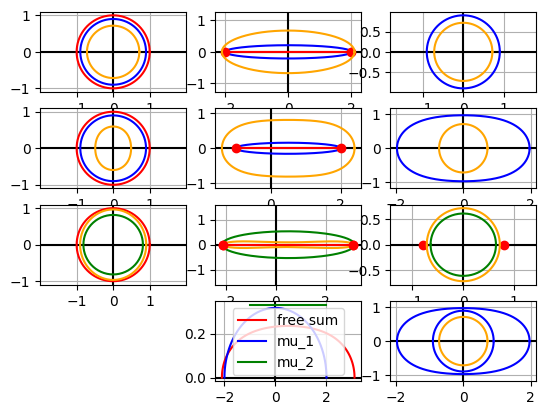

In [13]:
import freeconvolution
N1 = 400
N2 = 4000
N = 4000
m = 20
epsilon = 0.1
do_plots = 1
[a, b, t, approx_density, muplus] = freeconvolution.free_additive_convolution(mu1, mu2, N1, N2, N, m, epsilon, do_plots)

If there are random matrices corresponding to the measures $\mu_1$ and $\mu_2$, we can qualitatively check that the output of the free convolution algorithm is correct, by comparing the output approx_density with the histogram of the eigenvalues of the sum of two random matrices.

/home/alice/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/alice/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


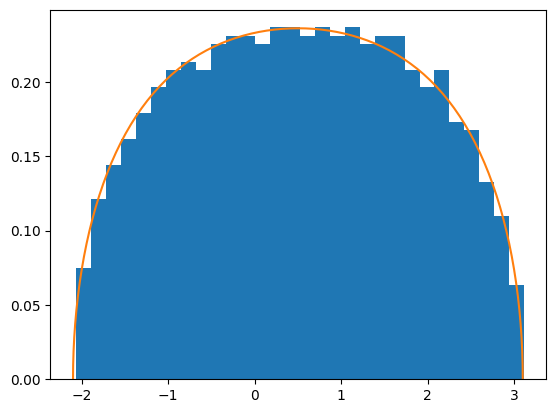

In [14]:
n = 1000
A1 = mu1.get_random_matrix(n)
A2 = mu2.get_random_matrix(n)
E = scipy.linalg.eigvals(A1 + A2)
n_bins = 30
(counts, bins) = numpy.histogram(E, bins=n_bins)
plt.hist(bins[:-1], bins, weights=n_bins / (n * (b - a)) * counts)
plt.plot(t, approx_density)

Looks pretty good! :)

### Computing the free multiplicative convolution

This is very similar to the additive example. 

The syntax for the free multiplicative convolution is the following:

[a, b, t, approx_density, mutimes] = free_multiplicative_convolution(mu1, mu2, N1, N2, N, m, epsilon, do_plots)


Inputs: 

  - mu1 and mu2 are the input measures
  - N1 = number of quadrature points for computing the T-transform of $\mu_1$ and its derivative. This depends on the regularity of $\mu_1$. If $\mu_1$ is very regular, for example if it has sqrt-behavior at the boundary (semicircle, Marchenko-Pastur, ...) a value of $N = 400$ may be enough. If $\mu_1$ is less regular, for instance for the uniform or ''weird'' distribution, $N$ should be larger, e.g. $N = 4000$.
  - N2 = number of quadrature points for computing the T-transform of $\mu_2$ and its derivative. Same reasoning as the previous point.
  - N = number of quadrature points for the discretizations of the Cauchy integral formulae, that is, for the computation of the S-transforms of $\mu_1$ and $\mu_2$, and for the computation of the T-transform of $\mu$. Choosing $N = \max\{N_1, N_2\}$ is quite safe.
  - m = number of series coefficients that we use in the approximation of the Cauchy transform of $\mu$. Typically, $m = 20$ should work. Ideally, this number can be chosen to be larger if the radius $r_C$ is large. If you obtain oscillating results, try with a smaller value of $m$.
  - epsilon = how close to "the border" do we want to get. Ideally, choose a value between 0.01 and 0.1. We refer to the paper for a more detailed description of what epsilon is and what are the advantages/disadvantages of choosing it too large or too small. If the computation of the support fails, try with a smaller value of epsilon (and increase number of quadrature points)
  - if do_plots == 1 it draws plots, otherwise not. The most understandable plot is the one in the (4,2) block: this represents the densities of the two input measures and the density of their free multiplicative convolution. For the other plots, see the paper.
  
Outputs:

- a, b is the support of $\mu_1 \boxtimes \mu_2$
- [t, approx_density] is a pair of arrays that describe the approximate density of $\mu$ on the interval $[a,b]$. $t$ are Chebyshev points in the interval $[a,b]$.

As an example, we show below how to compute the free multiplicative convolution of a Marchenko-Pastur distribution with parameter 0.1 and a uniform distribution on the interval $[1, 2]$.

STEP 1: Setting up the S-transform for mu1 and mu2
-- Setting up T and T_prime for mu1
-- Setting up T_inverse for mu1
-- Setting up T and T_prime for mu2
-- Setting up T_inverse for mu2
STEP 2: Computing support of mu
-- Computed support of mu: [ 0.6192367072191332 ,  2.8393546968540258 ]
STEP 3: Evaluating T_mu on a suitable curve
-- Computing orange circle
-- Finished binary search on the radius 
-- Choosing green circle A
-- Radius of green circle:  0.8125670557359279
-- M =  400 , m =  20
-- Evaluation of T_mu on green ellipse
STEP 4: Recover density of mu from its T-transform


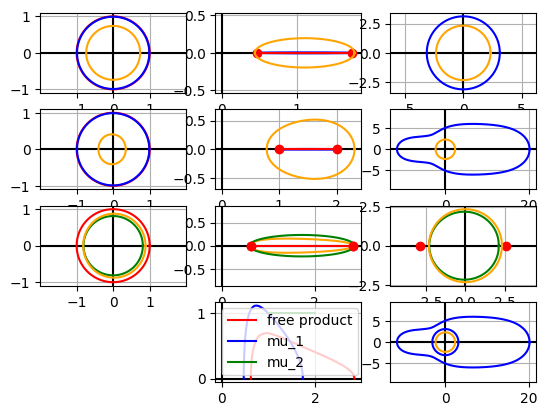

In [15]:
del(mu1)
mu1 = spectral_measure.spectral_measure()
mu1.set_marchenko_pastur(0.1)
del(mu2)
mu2 = spectral_measure.spectral_measure()
mu2.set_uniform(1, 2)

import freeconvolution
N1 = 800
N2 = 4000
N = 4000
m = 20
epsilon = 0.01
do_plots = 1
[a, b, t, approx_density, mutimes] = freeconvolution.free_multiplicative_convolution(mu1, mu2, N1, N2, N, m, epsilon, do_plots)

And, again, the comparison with the eigenvalues of the product of two random matrices chosen according to the $\mu_1$ and $\mu_2$ distrbution looks good.

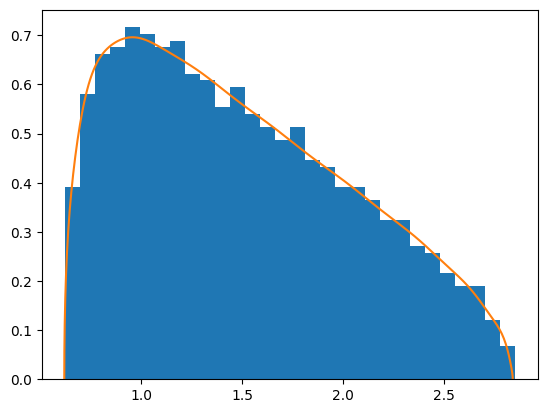

In [16]:
n = 1000
A1 = mu1.get_random_matrix(n)
A2 = mu2.get_random_matrix(n)
E = scipy.linalg.eigvals(numpy.matmul(A1, A2))
n_bins = 30
(counts, bins) = numpy.histogram(E, bins=n_bins)
plt.hist(bins[:-1], bins, weights=n_bins / (n * (b - a)) * counts)
plt.plot(t, approx_density)